In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/美国GDP.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['GDP:美国:同比'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=1, freq='QE')  # 改为季度频率,预测4个季度
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='QE')  # 改为季度频率
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,GDP:美国:同比,美国:个人消费支出:不变价:季调同比,美国ISM制造业PMI,美国:联邦政府财政赤字:同比,全球制造业PMI
2025-01-31,NaN,0.0306,50.9,486.59,50.1
2025-02-28,NaN,0.0293,50.3,3.63,50.6
2025-03-31,2.05,0.0326,49.0,-32.14,50.3
2025-04-30,NaN,NaN,48.7,NaN,NaN
2025-06-30,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['GDP:美国:同比', '美国:个人消费支出:不变价:季调同比', '美国ISM制造业PMI', '美国:联邦政府财政赤字:同比',
       '全球制造业PMI'],
      dtype='object')

In [6]:
################################# 处理缺失值 #################################
fill_methods = {
'美国:个人消费支出:不变价:季调同比':'interpolate', 
'美国ISM制造业PMI':'interpolate', 
'美国:联邦政府财政赤字:同比':'interpolate',
'全球制造业PMI':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['美国:个人消费支出:不变价:季调同比_提前2月'] = sheet['美国:个人消费支出:不变价:季调同比'].shift(2)
sheet['美国ISM制造业PMI_提前3月'] = sheet['美国ISM制造业PMI'].shift(3)
sheet['美国:联邦政府财政赤字:同比_提前2月'] = sheet['美国:联邦政府财政赤字:同比'].shift(2)
sheet['全球制造业PMI_提前1月'] = sheet['全球制造业PMI'].shift(1)

sheet['全球制造业PMI_提前1月_逆序'] = reverse_column(sheet, '全球制造业PMI_提前1月')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2015-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['GDP:美国:同比'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [7]:
# 将数据转换为季度频率
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
sheet_daily = sheet_daily.set_index('Date')
sheet_daily = sheet_daily.resample('QE').last()
sheet_daily = sheet_daily.reset_index()

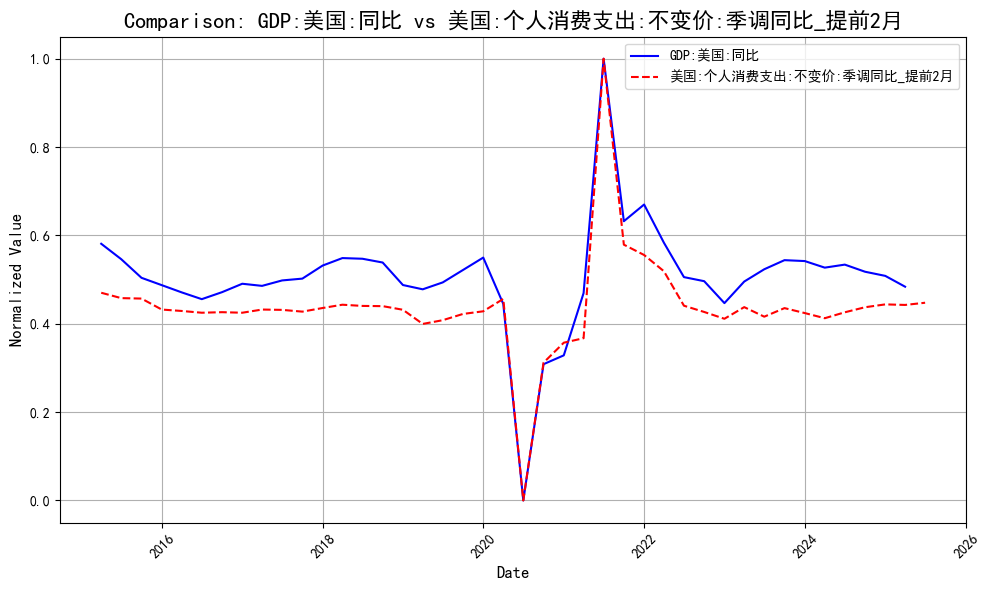

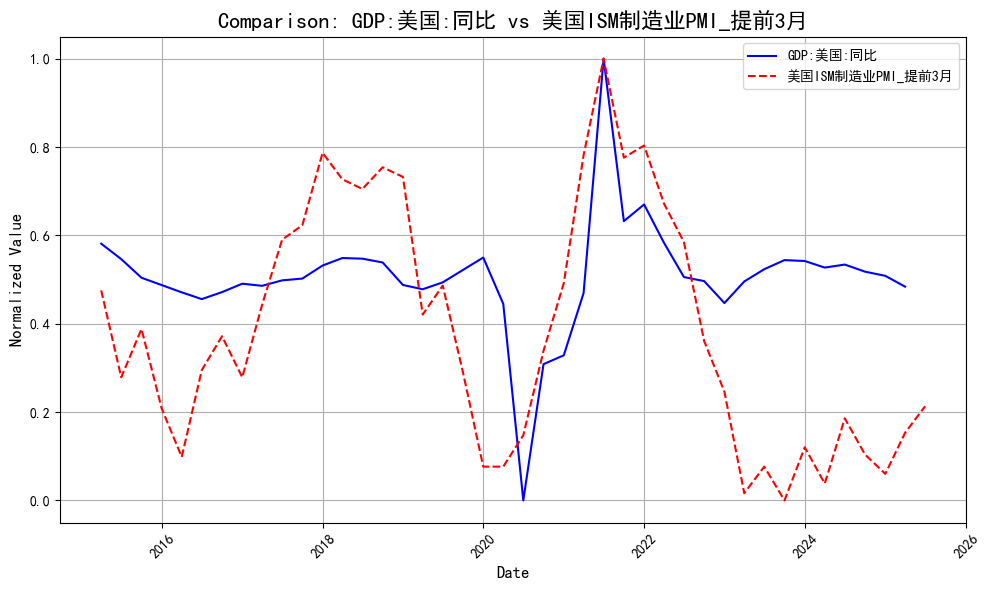

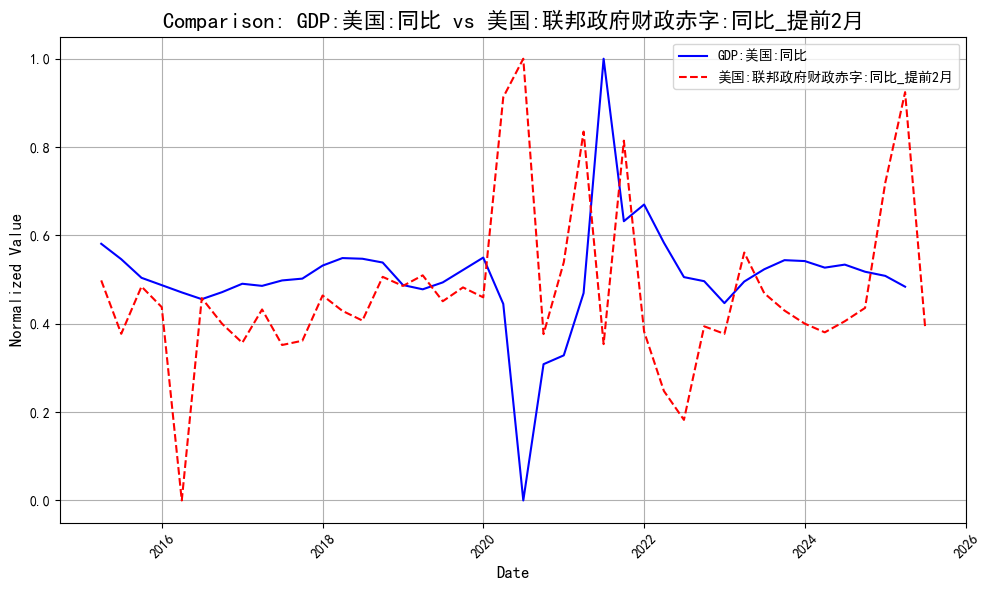

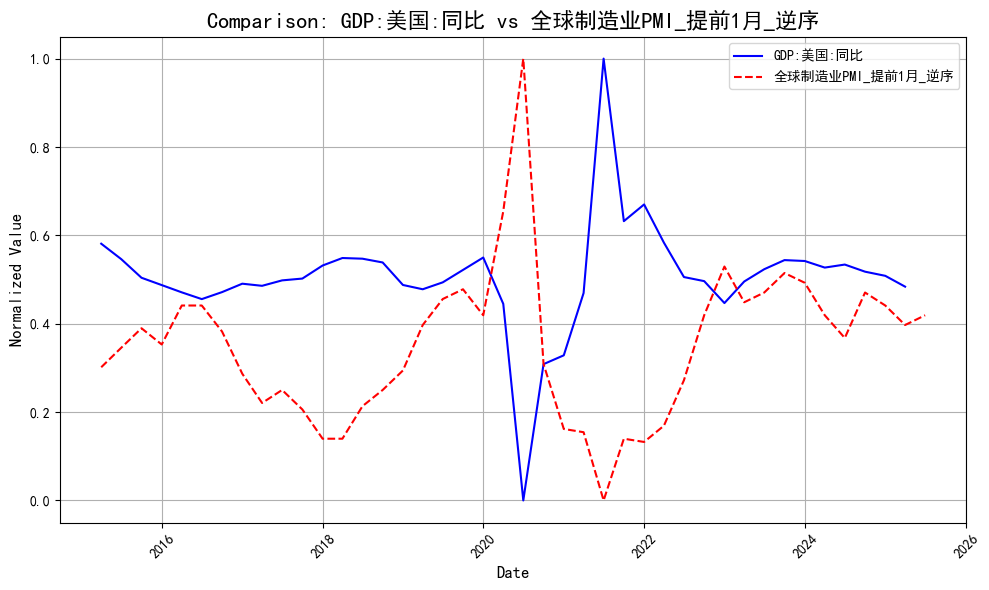

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='GDP:美国:同比', 
    compare_cols=[
        '美国:个人消费支出:不变价:季调同比_提前2月',
        '美国ISM制造业PMI_提前3月',
        '美国:联邦政府财政赤字:同比_提前2月',
        '全球制造业PMI_提前1月_逆序',
        ]
)

In [9]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 1
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '美国:个人消费支出:不变价:季调同比_提前2月',
        '美国ISM制造业PMI_提前3月',
        '美国:联邦政府财政赤字:同比_提前2月',
        '全球制造业PMI_提前1月_逆序',
]

predict_column = 'GDP:美国:同比'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'booster': 'gblinear',  # 使用树模型而不是线性模型
    'learning_rate': 0.01,  # 降低学习率以更好拟合
    'max_depth': 6,  # 树的最大深度
    'min_child_weight': 1, # 最小子节点权重
    'subsample': 0.8,  # 随机采样训练样本
    'colsample_bytree': 0.8, # 随机采样特征
    'reg_alpha': 0.01,  # 降低L1正则化
    'reg_lambda': 0.1,  # 降低L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42  # 随机种子
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.46700	train-rmse:1.75611
[500]	eval-rmse:0.17644	train-rmse:0.78136
[1000]	eval-rmse:0.19476	train-rmse:0.77404


c:\Users\hzins\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[1500]	eval-rmse:0.19494	train-rmse:0.77376
[2000]	eval-rmse:0.19495	train-rmse:0.77374
[2159]	eval-rmse:0.19495	train-rmse:0.77374
训练集 MSE (DMatrix): 0.6849, 训练集 R² (DMatrix): 0.8926
测试集 MSE (DMatrix): 0.038, 测试集 R² (DMatrix): nan


c:\Users\hzins\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


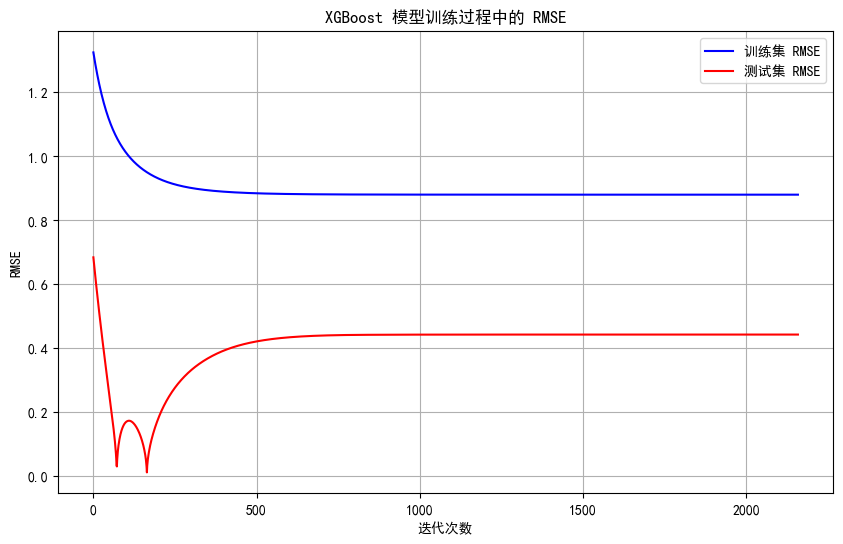

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:1.73576


c:\Users\hzins\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[500]	train-rmse:0.77499
[1000]	train-rmse:0.76780
[1500]	train-rmse:0.76756
[2000]	train-rmse:0.76755
[2087]	train-rmse:0.76755
全部数据 MSE: 0.674, 全部数据 R²: 0.8917


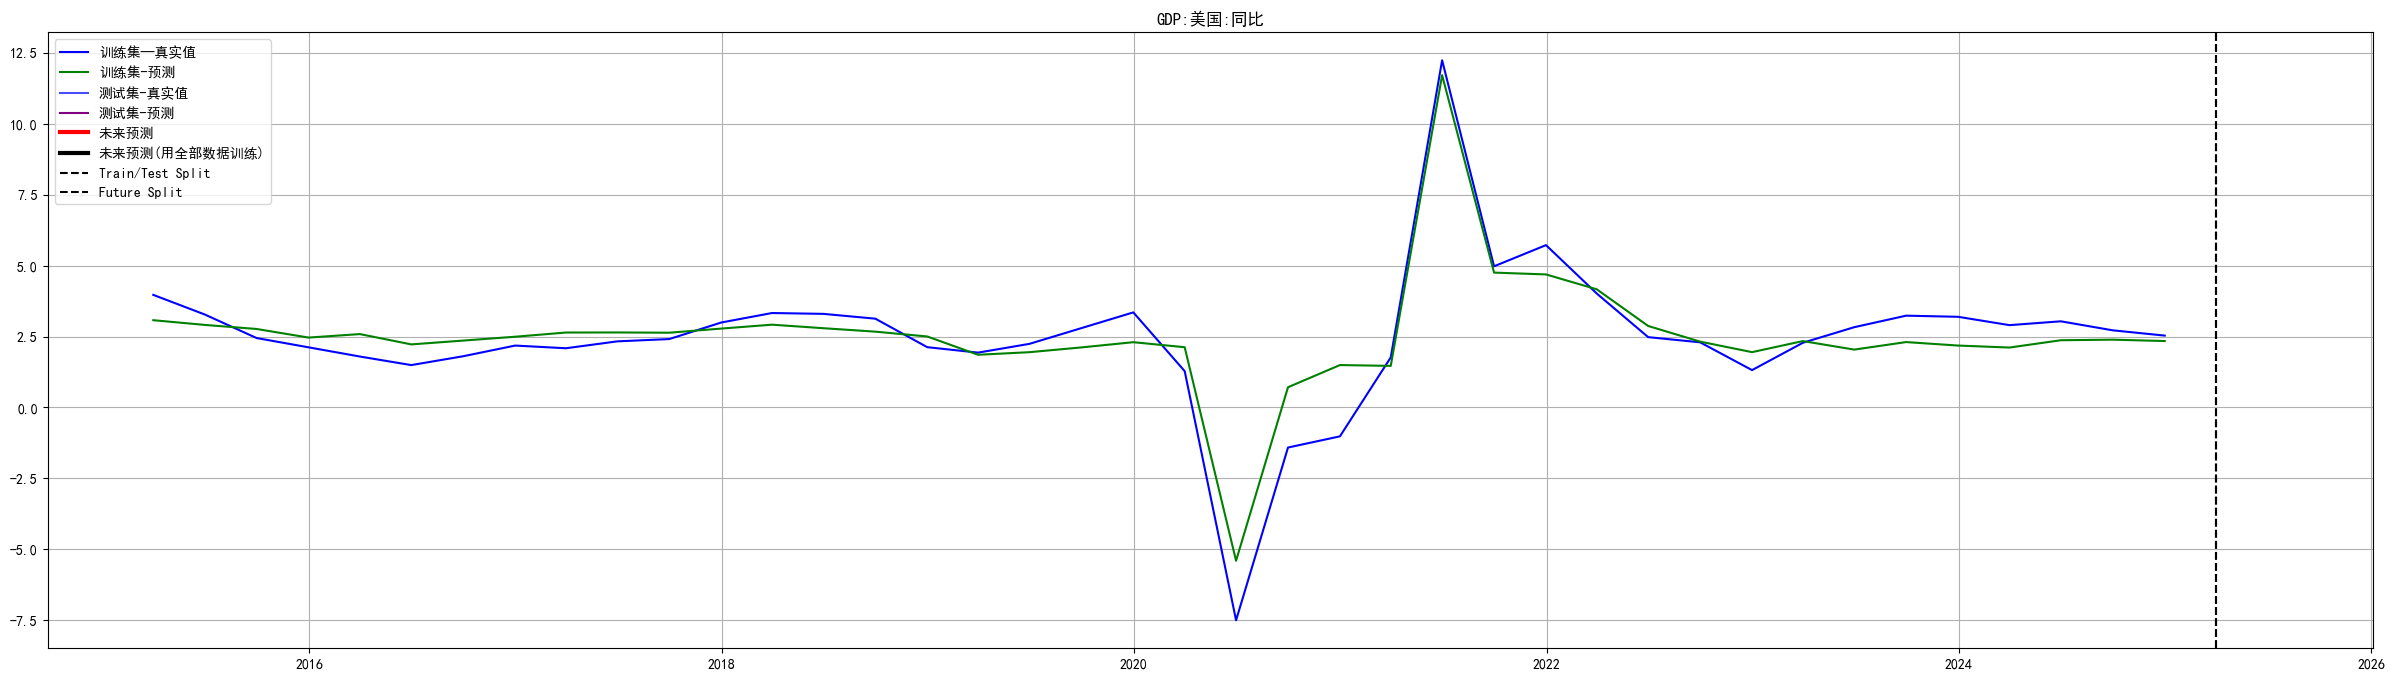

In [12]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red', linewidth=3)
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black', linewidth=3)

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('GDP:美国:同比')
plt.legend()
plt.grid(True)
plt.show()

---

In [13]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2020]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/GDP美国同比_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
21,2025/06/30,NaN,2.640866
20,2025/03/31,2.0500,NaN
19,2024/12/31,2.5335,NaN
18,2024/09/30,2.7189,NaN
17,2024/06/30,3.0369,NaN
16,2024/03/31,2.9018,NaN
15,2023/12/31,3.1960,NaN
14,2023/09/30,3.2361,NaN
13,2023/06/30,2.8295,NaN
12,2023/03/31,2.2804,NaN


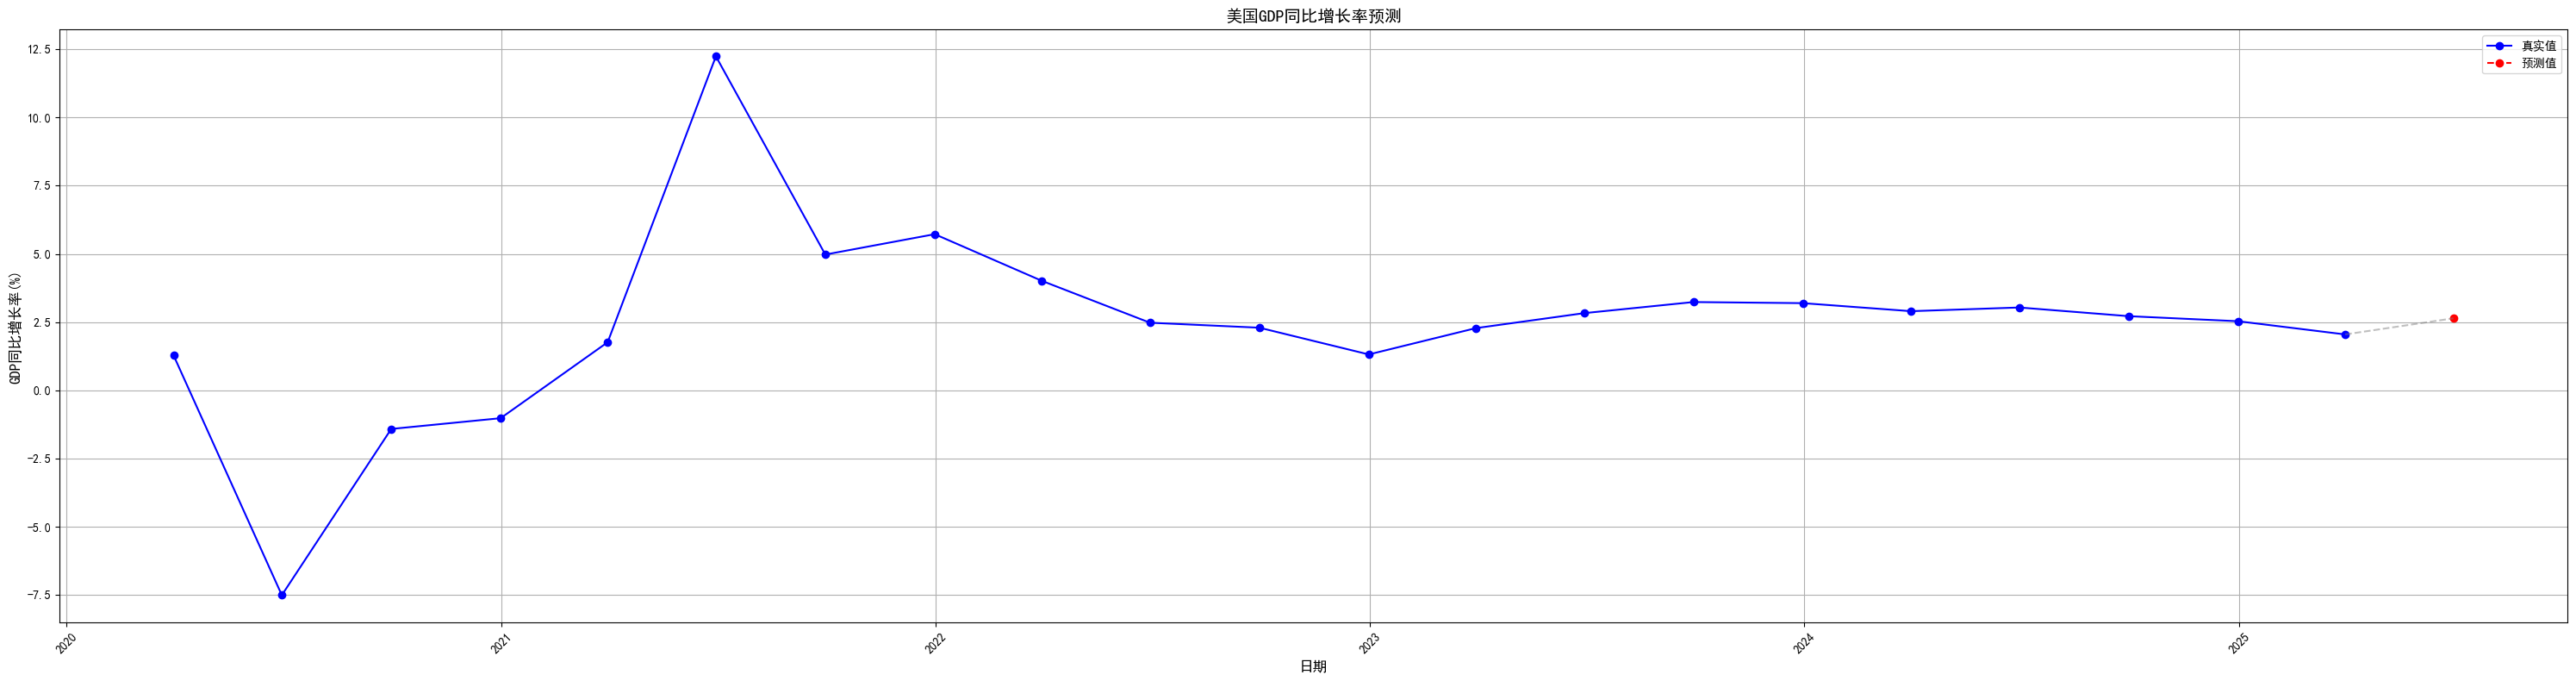

In [14]:
# 绘制日度数据图表
plt.figure(figsize=(30, 8))

# 绘制真实值和预测值
plt.plot(pd.to_datetime(merged_df_daily['Date']), merged_df_daily['真实值'], label='真实值', marker='o', color='blue')
# 只绘制非空的预测值数据点
mask = pd.notna(merged_df_daily['预测值'])
plt.plot(pd.to_datetime(merged_df_daily.loc[mask, 'Date']), 
         merged_df_daily.loc[mask, '预测值'],
         label='预测值', marker='o', color='red', linestyle='--')

# 连接真实值和预测值的交界处
last_actual = merged_df_daily[pd.notna(merged_df_daily['真实值'])].iloc[0]
first_pred = merged_df_daily[pd.notna(merged_df_daily['预测值'])].iloc[-1]
plt.plot([pd.to_datetime(last_actual['Date']), pd.to_datetime(first_pred['Date'])],[last_actual['真实值'], first_pred['预测值']], color='gray', linestyle='--', alpha=0.5)
plt.title('美国GDP同比增长率预测', fontsize=14)
plt.xlabel('日期', fontsize=12)
plt.ylabel('GDP同比增长率(%)', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2020]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('QE').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 限制小数位数为4位
merged_df_monthly['真实值'] = merged_df_monthly['真实值'].round(4)
merged_df_monthly['预测值'] = merged_df_monthly['预测值'].round(4)
# 保存成excel
merged_df_monthly.to_excel('eta/GDP美国同比_月度数据.xlsx', index=False, float_format='%.4f')
merged_df_monthly

,Date,真实值,预测值
21,2025/06/30,NaN,2.6409
20,2025/03/31,2.0500,2.2449
19,2024/12/31,2.5335,2.3411
18,2024/09/30,2.7189,2.3901
17,2024/06/30,3.0369,2.3698
16,2024/03/31,2.9018,2.1123
15,2023/12/31,3.1960,NaN
14,2023/09/30,3.2361,NaN
13,2023/06/30,2.8295,NaN
12,2023/03/31,2.2804,NaN


In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "GDP:美国:同比"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
'''
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "GDP:美国:同比"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfile_path = "eta/1.宏观经济_数据上传.xlsx"\nsheet_name = "详情页"\nidentifier = "GDP:美国:同比"\n\n# 调用函数更新数据\nsuccess = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'

In [ ]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "欧元/美元"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")